In [1]:
%load_ext pycodestyle_magic

In [2]:
# %%pycodestyle

# Required libraries
import datetime as dt
import matplotlib.pyplot as plt

import os
import time
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 

start = time.time()

In [3]:
# Constants
my_data = "../data"

# Load data

In [4]:
# Load data into Pandas dataframe
datafile = "datazon_customer_data.csv"
full_path = os.path.join(my_data, datafile)
df_customers = pd.read_csv(full_path)
print(df_customers.shape)

(4323, 9)


In [5]:
# Sample data to get a certain knowledge of the dataframe content
df_customers.head()

,CustomerID,InvoiceNumberYear,LastInvoiceMonth,LastInvoiceMonthNb,MeanLinesPerInvoice,MeanQuantityPerInvoice,MeanAmountPerInvoice,TotalAmountSpent,cluster_k
0,12347,7,201112,0,26.00,351.142857,615.714286,4310.00,0
1,12348,4,201109,3,6.75,583.000000,359.310000,1437.24,4
2,12349,1,201111,1,72.00,630.000000,1457.550000,1457.55,7
3,12350,1,201102,10,16.00,196.000000,294.400000,294.40,1
4,12352,7,201111,1,10.00,66.142857,180.772857,1265.41,4


In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # print(cm)
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Define classification functions

## Logistic regression

In [7]:
def LogisticRegressionCl(X_train, X_test, y_train, y_test):
    
    # First run of LR is without regularization
    lr = LogisticRegression()
    acc_scorer = make_scorer(accuracy_score)
    
    lr.fit(X_train,y_train)

    y_pred = lr.predict(X_test)

    print("Non regularized Logistic Regression Accuracy Score on test set {0:.2f}".format(accuracy_score(y_test, y_pred)))

    # second run of LR is with regularization
    lr = LogisticRegression()
    params = {'C': np.logspace(-3, 3, 7) , 'penalty':['l1','l2'] }
    acc_scorer = make_scorer(accuracy_score)

    gs_lr = GridSearchCV(lr, params)

    gs_lr.fit(X_train, y_train)

    y_pred = gs_lr.predict(X_test)
    
    print("Regularized Logistic Regression best params {0}".format(gs_lr.best_params_))
    print("Regularized Logistic Regression Accuracy Score on test set {0:.2f}".format(accuracy_score(y_test, y_pred)))
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=y_test.drop_duplicates().sort_values())
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=y_test.drop_duplicates().sort_values(), normalize=True,
                          title='Normalized Confusion matrix, Logistic Regression')
    result = pd.DataFrame({'Real': y_test, 'Predict': y_pred})
    return(result)

## Linear Support Vector Classification

In [8]:
def SVMCl(X_train, X_test, y_train, y_test):

    svm = LinearSVC()

    params = { 'C': np.logspace(-4, 4, 9) }

    gs_svm = GridSearchCV(svm, params)
    gs_svm.fit(X_train, y_train)

    y_pred = gs_svm.predict(X_test)
    
    print("SVM classification best params {0}".format(gs_svm.best_params_))
    print("SVM classification Accuracy Score on test set {0:.2f}".format(accuracy_score(y_test, y_pred)))
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=y_test.drop_duplicates().sort_values())
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=y_test.drop_duplicates().sort_values(), normalize=True,
                          title='Normalized Confusion matrix, SVM')
    result = pd.DataFrame({'Real': y_test, 'Predict': y_pred})
    return(result)

## Random Forest

In [9]:
def RandomForestCl(X_train, X_test, y_train, y_test):

    rfc = RandomForestClassifier()
    params = { 'n_estimators': [50, 100, 200, 500, 1000] }
    acc_scorer = make_scorer(accuracy_score)
    
    gs_rfc = GridSearchCV(rfc, params, scoring=acc_scorer)
    
    model = gs_rfc.fit(X_train, y_train)
    
    y_pred = gs_rfc.predict(X_test)

    print("Random Forest best params {0}".format(gs_rfc.best_params_))
    print("Random Forest Accuracy Score on test set {0:.2f}".format(accuracy_score(y_test, y_pred)))
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=y_test.drop_duplicates().sort_values())
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=y_test.drop_duplicates().sort_values(), normalize=True,
                          title='Normalized Confusion matrix, Random Forest')
    result = pd.DataFrame({'Real': y_test, 'Predict': y_pred})
    return(result)

## AdaBoost classifier

In [10]:
def AdaBoostCl(X_train, X_test, y_train, y_test):
    
    adaboost = AdaBoostClassifier()
    params = { 'n_estimators': [50, 100, 150, 200], 'learning_rate': np.logspace(-4, 0, 9) }
    acc_scorer = make_scorer(accuracy_score) #Pas nécessaire avec AdBosst car sa fonction score est de base accuracy

    gs_adaboost = GridSearchCV(adaboost, params, scoring=acc_scorer)

    gs_adaboost.fit(X_train, y_train)

    y_pred = gs_adaboost.predict(X_test)
    
    print("AdaBoost best params {0}".format(gs_adaboost.best_params_))
    print("AdaBoost Accuracy Score on test set {0:.2f}".format(accuracy_score(y_test, y_pred)))
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=y_test.drop_duplicates().sort_values())
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=y_test.drop_duplicates().sort_values(), normalize=True,
                          title='Normalized Confusion matrix, AdaBoost')
    result = pd.DataFrame({'Real': y_test, 'Predict': y_pred})
    return(result)

In [11]:
def run_all_algos():
    # Create plot grid for confusion matrixes
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    # Run logistic regression
    ax1 = plt.subplot(2,2,1)
    lr_res = LogisticRegressionCl(X_train, X_test, y_train, y_test)
    lr_res['compteur'] = 1
    print()
    
    # Run SVM
    plt.subplot(2,2,2, sharex=ax1)
    svm_res = SVMCl(X_train, X_test, y_train, y_test)
    svm_res['compteur'] = 1
    print()
    
    #Run Random Forest
    plt.subplot(2,2,3, sharex=ax1)
    rfc_res = RandomForestCl(X_train, X_test, y_train, y_test)
    rfc_res['compteur'] = 1
    print()
    
    # Run AdaBoost
    plt.subplot(2,2,4, sharex=ax1)
    ab_res = AdaBoostCl(X_train, X_test, y_train, y_test)
    ab_res['compteur'] = 1

    # Display the 4 confusion matrixes
    plt.show()
    
    return(lr_res, svm_res, rfc_res, ab_res)

# Run classifiers on several train sets

## 1. Test set included in initial clustering

This run takes a dataset which was clustered as a whole: train and test samples together. This is likely to cause data leakage.

Non regularized Logistic Regression Accuracy Score on test set 0.87
Regularized Logistic Regression best params {'C': 1000.0, 'penalty': 'l1'}
Regularized Logistic Regression Accuracy Score on test set 0.89

SVM classification best params {'C': 0.001}
SVM classification Accuracy Score on test set 0.73

Random Forest best params {'n_estimators': 50}
Random Forest Accuracy Score on test set 0.98

AdaBoost best params {'learning_rate': 0.031622776601683791, 'n_estimators': 50}
AdaBoost Accuracy Score on test set 0.89


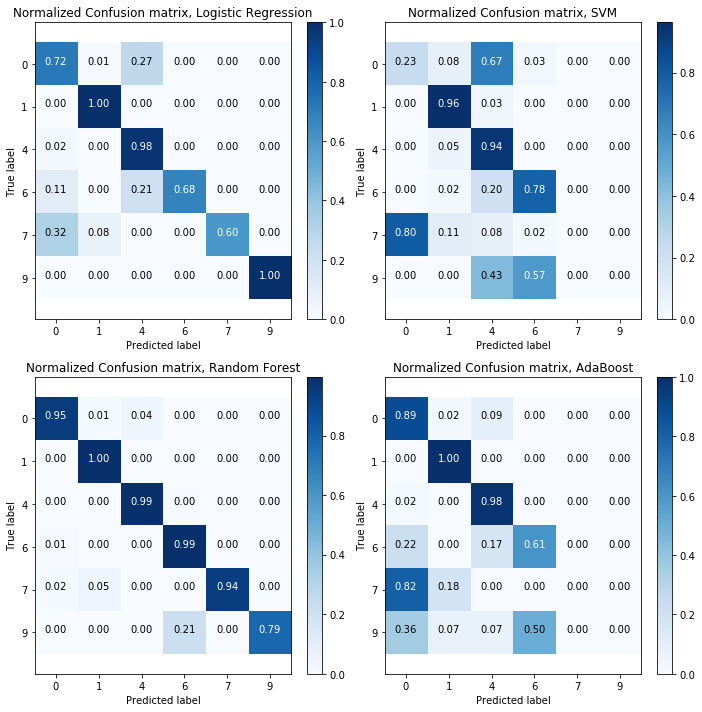

In [12]:
# Separate features and labels
X = df_customers[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                                      'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                                      'TotalAmountSpent']]
y = df_customers['cluster_k']

# Random sampling for train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

lr_res1, svm_res1, rfc_res1, ab_res1 = run_all_algos()

## 2. Clustering done only on train sets, test set labelled in a second step

In this approach, the customer base was spplit in train and test set, then the train set was classified by a k-means clustering, and finally the test set was labelled using the classifier predict function.

(2896, 9)
(1427, 9)
Non regularized Logistic Regression Accuracy Score on test set 0.88
Regularized Logistic Regression best params {'C': 100.0, 'penalty': 'l1'}
Regularized Logistic Regression Accuracy Score on test set 0.91

SVM classification best params {'C': 0.001}
SVM classification Accuracy Score on test set 0.77

Random Forest best params {'n_estimators': 1000}
Random Forest Accuracy Score on test set 0.98

AdaBoost best params {'learning_rate': 0.31622776601683794, 'n_estimators': 150}
AdaBoost Accuracy Score on test set 0.89


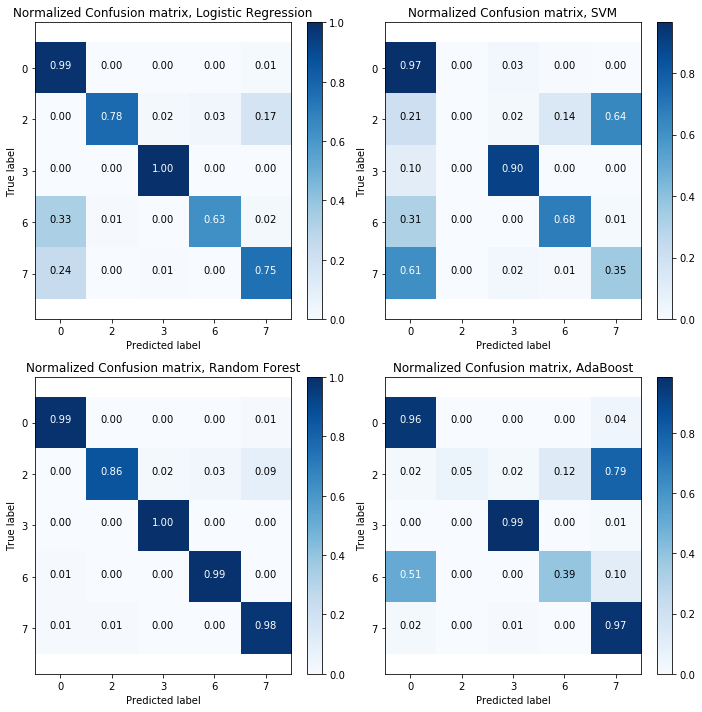

In [13]:
# Load data into Pandas dataframe
datafile = "datazon_customer_data_2_train.csv"
full_path = os.path.join(my_data, datafile)
df_customers_train = pd.read_csv(full_path)
print(df_customers_train.shape)

# Load data into Pandas dataframe
datafile = "datazon_customer_data_2_test.csv"
full_path = os.path.join(my_data, datafile)
df_customers_test = pd.read_csv(full_path)
print(df_customers_test.shape)

X_train = df_customers_train[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                              'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                              'TotalAmountSpent']]
y_train = df_customers_train['cluster_k']

X_test = df_customers_test[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                            'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                            'TotalAmountSpent']]
y_test = df_customers_test['cluster_k']

lr_res2, svm_res2, rfc_res2, ab_res2 = run_all_algos()

## 3. Time biased train and test sets

(1151, 9)
(3172, 9)
Non regularized Logistic Regression Accuracy Score on test set 0.69
Regularized Logistic Regression best params {'C': 1000.0, 'penalty': 'l1'}
Regularized Logistic Regression Accuracy Score on test set 0.65

SVM classification best params {'C': 10.0}
SVM classification Accuracy Score on test set 0.47

Random Forest best params {'n_estimators': 200}
Random Forest Accuracy Score on test set 0.96

AdaBoost best params {'learning_rate': 0.31622776601683794, 'n_estimators': 150}
AdaBoost Accuracy Score on test set 0.88


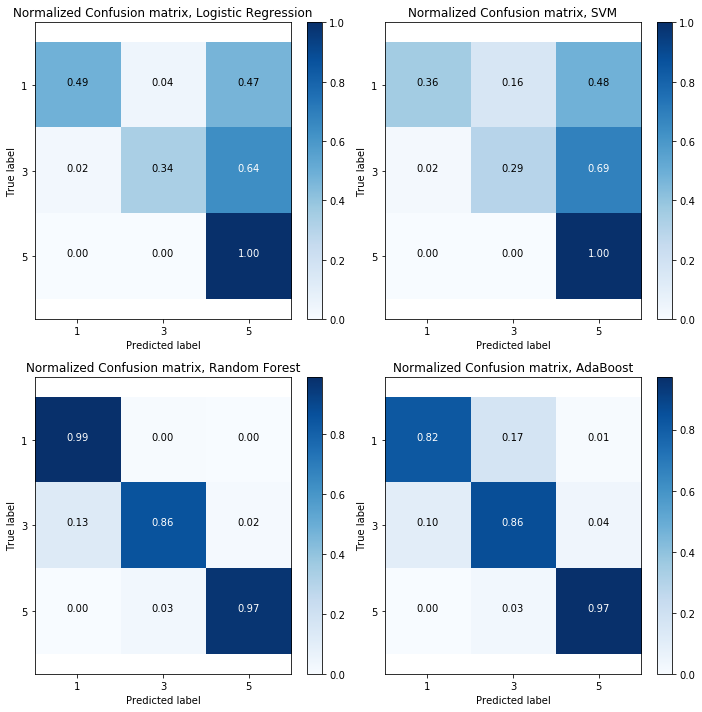

In [14]:
# Load data into Pandas dataframe
datafile = "datazon_customer_data_3_train.csv"
full_path = os.path.join(my_data, datafile)
df_customers_train = pd.read_csv(full_path)
print(df_customers_train.shape)

# Load data into Pandas dataframe
datafile = "datazon_customer_data_3_test.csv"
full_path = os.path.join(my_data, datafile)
df_customers_test = pd.read_csv(full_path)
print(df_customers_test.shape)

X_train = df_customers_train[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                              'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                              'TotalAmountSpent']]
y_train = df_customers_train['cluster_k']

X_test = df_customers_test[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                            'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                            'TotalAmountSpent']]
y_test = df_customers_test['cluster_k']

lr_res3, svm_res3, rfc_res3, ab_res3 = run_all_algos()

In [16]:
svm_res3.groupby(['Real', 'Predict']).count()

compteur
Real Predict          
1    0             674
     1             263
     3             117
     5             357
3    0             162
     1               9
     3             126
     5             295
5    0              78
     5            1091

## 4. Value biased train and test sets

(3242, 9)
(4323, 9)
Non regularized Logistic Regression Accuracy Score on test set 0.84
Regularized Logistic Regression best params {'C': 100.0, 'penalty': 'l1'}
Regularized Logistic Regression Accuracy Score on test set 0.85

SVM classification best params {'C': 0.001}
SVM classification Accuracy Score on test set 0.83

Random Forest best params {'n_estimators': 100}
Random Forest Accuracy Score on test set 0.85

AdaBoost best params {'learning_rate': 0.01, 'n_estimators': 200}
AdaBoost Accuracy Score on test set 0.22


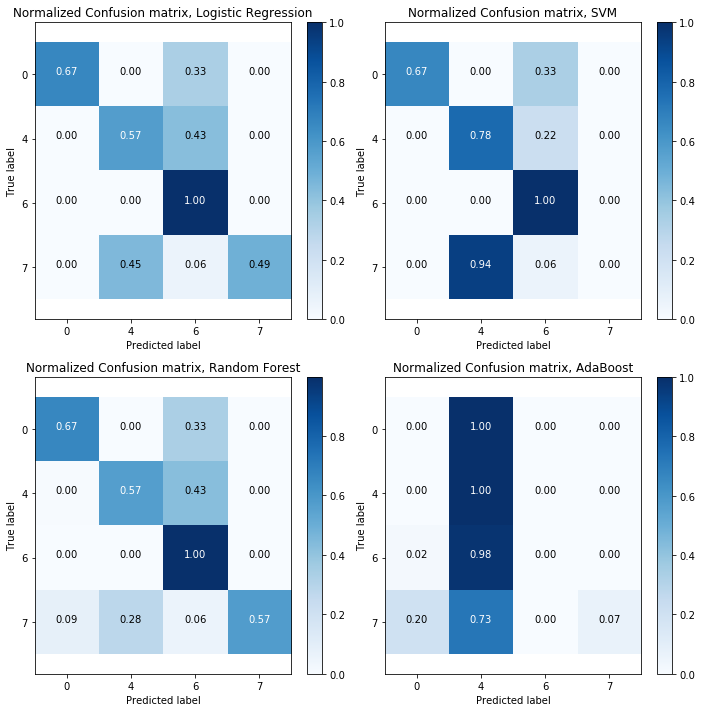

In [17]:
# Load data into Pandas dataframe
datafile = "datazon_customer_data_4_train.csv"
full_path = os.path.join(my_data, datafile)
df_customers_train = pd.read_csv(full_path)
print(df_customers_train.shape)

# Load data into Pandas dataframe
datafile = "datazon_customer_data_4_test.csv"
full_path = os.path.join(my_data, datafile)
df_customers_test = pd.read_csv(full_path)
print(df_customers.shape)

X_train = df_customers_train[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                              'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                              'TotalAmountSpent']]
y_train = df_customers_train['cluster_k']

X_test = df_customers_test[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                            'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                            'TotalAmountSpent']]
y_test = df_customers_test['cluster_k']

lr_res4, svm_res4, rfc_res4, ab_res4 = run_all_algos()

In [21]:
rfc_res1.groupby(['Real', 'Predict']).count()

compteur
Real Predict          
0    0             285
     1               4
     4              12
1    1             298
     7               1
4    0               1
     4             645
     6               3
6    0               1
     6              98
7    0               1
     1               3
     7              61
9    6               3
     9              11